In [ ]:
import os
import random
import shutil

# 원본 데이터 경로
original_train_dir = "path/to/original/train"
original_val_dir = "path/to/original/val"

# 결과 저장 경로
output_dir = "path/to/output"
os.makedirs(output_dir, exist_ok=True)

# 데이터셋 분할 경로
train_output = os.path.join(output_dir, "train")
val_output = os.path.join(output_dir, "val")
test_output = os.path.join(output_dir, "test")

# 각 폴더 생성
os.makedirs(train_output, exist_ok=True)
os.makedirs(val_output, exist_ok=True)
os.makedirs(test_output, exist_ok=True)

# 카테고리별로 데이터를 나누는 함수
def split_data(input_dir, train_out, val_out, test_out, train_size=600, val_size=100, test_from_train=100):
    categories = os.listdir(input_dir)  # 카테고리 폴더 리스트
    for category in categories:
        category_dir = os.path.join(input_dir, category)
        if not os.path.isdir(category_dir):
            continue  # 폴더가 아닌 경우 건너뜀

        # 저장 폴더 생성
        train_cat_dir = os.path.join(train_out, category)
        val_cat_dir = os.path.join(val_out, category)
        test_cat_dir = os.path.join(test_out, category)
        os.makedirs(train_cat_dir, exist_ok=True)
        os.makedirs(val_cat_dir, exist_ok=True)
        os.makedirs(test_cat_dir, exist_ok=True)

        # 이미지 파일 가져오기
        images = os.listdir(category_dir)
        random.shuffle(images)

        # train, val, test 데이터 분리
        train_images = images[:train_size]
        val_images = images[-val_size:]
        test_images = train_images[:test_from_train]

        # 파일 복사
        for img in train_images:
            shutil.copy(os.path.join(category_dir, img), os.path.join(train_cat_dir, img))

        for img in val_images:
            shutil.copy(os.path.join(category_dir, img), os.path.join(val_cat_dir, img))

        for img in test_images:
            shutil.copy(os.path.join(category_dir, img), os.path.join(test_cat_dir, img))

# train 데이터에서 분할
split_data(original_train_dir, train_output, val_output, test_output)

print("데이터 분할 완료!")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

# 데이터 경로 설정
train_dir2 = "D:/ko_food/train"
val_dir2 = "D:/ko_food/val"
test_dir2 = "D:/ko_food/test"

# 데이터 전처리
train_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator2 = train_datagen2.flow_from_directory(
    train_dir2,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator2 = val_test_datagen2.flow_from_directory(
    val_dir2,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

test_generator2 = val_test_datagen2.flow_from_directory(
    test_dir2,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# 사전학습 및 Fine-tuning 모델 정의
def create_model(num_classes, fine_tune_at=None):
    # 사전학습된 ResNet101 모델 로드
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # 특정 레이어 이후부터 Fine-tuning 설정
    if fine_tune_at is not None:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False  # 하위 레이어는 고정
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True  # 상위 레이어는 학습 가능
    else:
        base_model.trainable = False  # 전체 레이어 고정

    # 모델 구성
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),  # 과적합 방지용 Dropout
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # 분류 레이어
    ])
    
    return model

# 학습 함수
def train_model(train_generator, val_generator, test_generator, num_classes):
    # 1단계: Feature Extraction (사전학습 모델 고정)
    print("Step 1: Training with Frozen Base Model...")
    model = create_model(num_classes, fine_tune_at=None)
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        ModelCheckpoint('resnet101_feature_extraction.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=callbacks
    )

    # 2단계: Fine-tuning (사전학습 모델의 상위 레이어 열기)
    print("Step 2: Fine-tuning the Base Model...")
    fine_tune_at = -30  # 상위 30개 레이어만 학습 가능
    model = create_model(num_classes, fine_tune_at=fine_tune_at)
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),  # 낮은 학습률로 설정
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks[2] = ModelCheckpoint('resnet101_finetuned.h5', save_best_only=True, monitor='val_loss', verbose=1)

    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=callbacks
    )

    # 테스트 데이터셋 평가
    print("\nEvaluating on the test dataset...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # 최종 모델 저장
    model.save('resnet101_korean_food_final_finetuned.h5')

# 학습 실행
if __name__ == "__main__":
    num_classes = 150  # 클래스 수
    train_model(train_generator2, val_generator2, test_generator2, num_classes)



Found 75000 images belonging to 150 classes.
Found 15000 images belonging to 150 classes.
Found 15000 images belonging to 150 classes.
Step 1: Training with Frozen Base Model...


171446536/171446536 [==============================] - 15s 0us/step
Epoch 1/10


  87/4688 [..............................] - ETA: 1:42:14 - loss: 5.3296 - accuracy: 0.0101

c:\Users\human\anaconda3\envs\human-dl-env2\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3806/4688 [=======================>......] - ETA: 19:54 - loss: 3.8147 - accuracy: 0.1401

c:\Users\human\anaconda3\envs\human-dl-env2\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


4688/4688 [==============================] - ETA: 0s - loss: 3.7221 - accuracy: 0.1521
Epoch 1: val_loss improved from inf to 2.51230, saving model to resnet101_feature_extraction.h5


c:\Users\human\anaconda3\envs\human-dl-env2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4688/4688 [==============================] - 7615s 2s/step - loss: 3.7221 - accuracy: 0.1521 - val_loss: 2.5123 - val_accuracy: 0.3759 - lr: 0.0010
Epoch 2/10
4688/4688 [==============================] - ETA: 0s - loss: 3.2380 - accuracy: 0.2173
Epoch 2: val_loss improved from 2.51230 to 2.41425, saving model to resnet101_feature_extraction.h5
4688/4688 [==============================] - 7534s 2s/step - loss: 3.2380 - accuracy: 0.2173 - val_loss: 2.4143 - val_accuracy: 0.3983 - lr: 0.0010
Epoch 3/10
4688/4688 [==============================] - ETA: 0s - loss: 3.1839 - accuracy: 0.2270
Epoch 3: val_loss improved from 2.41425 to 2.39790, saving model to resnet101_feature_extraction.h5
4688/4688 [==============================] - 7538s 2s/step - loss: 3.1839 - accuracy: 0.2270 - val_loss: 2.3979 - val_accuracy: 0.4029 - lr: 0.0010
Epoch 4/10
4688/4688 [==============================] - ETA: 0s - loss: 3.1841 - accuracy: 0.2305
Epoch 4: val_loss did not improve from 2.39790
4688/4688 [====

In [1]:
import tensorflow as tf

In [6]:
print("Keras Version:", tf.keras.__version__)

Keras Version: 3.8.0


In [7]:
import sys
print(sys.version)

3.10.12 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 19:01:18) [MSC v.1916 64 bit (AMD64)]


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.regularizers import l2


# 데이터 경로 설정
train_dir2 = "D:/K_food_for_corab/train"
val_dir2 = "D:/K_food_for_corab/validation"
test_dir2 = "D:/K_food_for_corab/test"

target_size = (256, 256)  # 입력 크기 통일

# 데이터 생성기 설정 (입력 크기 통일)
train_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator2 = train_datagen2.flow_from_directory(
    train_dir2,
    target_size=target_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator2 = val_test_datagen2.flow_from_directory(
    val_dir2,
    target_size=target_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

test_generator2 = val_test_datagen2.flow_from_directory(
    test_dir2,
    target_size=target_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 105000 images belonging to 150 classes.
Found 21000 images belonging to 150 classes.
Found 21000 images belonging to 150 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecays

# 데이터 경로 설정
train_dir2 = "D:/K_food_for_corab/train"
val_dir2 = "D:/K_food_for_corab/validation"
test_dir2 = "D:/K_food_for_corab/test"

# 데이터 생성기 설정 (입력 크기 통일)
train_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)

target_size = (256, 256)  # 입력 크기 통일

train_generator2 = train_datagen2.flow_from_directory(
    train_dir2,
    target_size=target_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator2 = val_test_datagen2.flow_from_directory(
    val_dir2,
    target_size=target_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

test_generator2 = val_test_datagen2.flow_from_directory(
    test_dir2,
    target_size=target_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# 사전학습 및 Fine-tuning 모델 정의
def create_model(num_classes, fine_tune_at=None):
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    if fine_tune_at is not None:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True
    else:
        base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))
    ])

    return model

# 학습 함수
def train_model(train_generator, val_generator, test_generator, num_classes):
    # 학습률 스케줄러 정의
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True
    )
    
    # 1단계: Feature Extraction (사전학습 모델 고정)
    print("Step 1: Training with Frozen Base Model...")
    model = create_model(num_classes, fine_tune_at=None)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        ModelCheckpoint('resnet101_feature_extraction.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=callbacks
    )

    # 2단계: Fine-tuning (사전학습 모델의 상위 레이어 열기)
    print("Step 2: Fine-tuning the Base Model...")
    model.layers[0].trainable = True  # Base model 수정 가능 설정
    for layer in model.layers[0].layers[:-30]:  # 특정 레이어까지만 고정
        layer.trainable = False

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks[2] = ModelCheckpoint('resnet101_finetuned.h5', save_best_only=True, monitor='val_loss', verbose=1)

    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=callbacks
    )

    # 테스트 데이터셋 평가
    print("\nEvaluating on the test dataset...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # 최종 모델 저장
    model.save('resnet101_korean_food_final_finetuned.h5')

# 학습 실행
if __name__ == "__main__":
    num_classes = 150
    train_model(train_generator2, val_generator2, test_generator2, num_classes)


Found 105000 images belonging to 150 classes.
Found 21000 images belonging to 150 classes.
Found 21000 images belonging to 150 classes.
Step 1: Training with Frozen Base Model...


c:\Users\human\anaconda3\envs\final-pj-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1102 - loss: 5.5817
Epoch 1: val_loss improved from inf to 3.85201, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 13184s 2s/step - accuracy: 0.1103 - loss: 5.5816 - val_accuracy: 0.3329 - val_loss: 3.8520 - learning_rate: 0.0010
Epoch 2/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1840 - loss: 4.4048
Epoch 2: val_loss improved from 3.85201 to 3.74438, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 13127s 2s/step - accuracy: 0.1840 - loss: 4.4048 - val_accuracy: 0.3552 - val_loss: 3.7444 - learning_rate: 9.0000e-04
Epoch 3/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1926 - loss: 4.3185
Epoch 3: val_loss improved from 3.74438 to 3.70513, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 12968s 2s/step - accuracy: 0.1926 - loss: 4.3185 - val_accuracy: 0.3615 - val_loss: 3.7051 - learning_rate: 9.0000e-04
Epoch 4/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1988 - loss: 4.2399
Epoch 4: val_loss improved from 3.70513 to 3.68364, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 12178s 2s/step - accuracy: 0.1988 - loss: 4.2399 - val_accuracy: 0.3838 - val_loss: 3.6836 - learning_rate: 8.1000e-04
Epoch 5/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2005 - loss: 4.2184
Epoch 5: val_loss improved from 3.68364 to 3.57802, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 12275s 2s/step - accuracy: 0.2005 - loss: 4.2184 - val_accuracy: 0.3867 - val_loss: 3.5780 - learning_rate: 7.2900e-04
Epoch 6/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2072 - loss: 4.1468
Epoch 6: val_loss improved from 3.57802 to 3.57800, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 12220s 2s/step - accuracy: 0.2072 - loss: 4.1468 - val_accuracy: 0.3921 - val_loss: 3.5780 - learning_rate: 7.2900e-04
Epoch 7/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2119 - loss: 4.1007
Epoch 7: val_loss improved from 3.57800 to 3.52686, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 12143s 2s/step - accuracy: 0.2119 - loss: 4.1007 - val_accuracy: 0.4022 - val_loss: 3.5269 - learning_rate: 6.5610e-04
Epoch 8/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2155 - loss: 4.0748
Epoch 8: val_loss improved from 3.52686 to 3.45628, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 12994s 2s/step - accuracy: 0.2155 - loss: 4.0748 - val_accuracy: 0.4189 - val_loss: 3.4563 - learning_rate: 5.9049e-04
Epoch 9/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2197 - loss: 4.0191
Epoch 9: val_loss improved from 3.45628 to 3.42800, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 13513s 2s/step - accuracy: 0.2197 - loss: 4.0191 - val_accuracy: 0.4040 - val_loss: 3.4280 - learning_rate: 5.9049e-04
Epoch 10/10
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2275 - loss: 3.9816
Epoch 10: val_loss improved from 3.42800 to 3.42474, saving model to resnet101_feature_extraction.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 13088s 2s/step - accuracy: 0.2275 - loss: 3.9816 - val_accuracy: 0.4280 - val_loss: 3.4247 - learning_rate: 5.3144e-04
Step 2: Fine-tuning the Base Model...
Epoch 1/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3575 - loss: 3.1550
Epoch 1: val_loss improved from inf to 1.88434, saving model to resnet101_finetuned.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16017s 2s/step - accuracy: 0.3575 - loss: 3.1549 - val_accuracy: 0.6348 - val_loss: 1.8843 - learning_rate: 1.0000e-04
Epoch 2/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5457 - loss: 2.2294
Epoch 2: val_loss improved from 1.88434 to 1.64370, saving model to resnet101_finetuned.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 15959s 2s/step - accuracy: 0.5457 - loss: 2.2294 - val_accuracy: 0.6824 - val_loss: 1.6437 - learning_rate: 1.0000e-04
Epoch 3/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6329 - loss: 1.8846
Epoch 3: val_loss improved from 1.64370 to 1.56221, saving model to resnet101_finetuned.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 15890s 2s/step - accuracy: 0.6329 - loss: 1.8846 - val_accuracy: 0.7119 - val_loss: 1.5622 - learning_rate: 1.0000e-04
Epoch 4/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6967 - loss: 1.6425
Epoch 4: val_loss improved from 1.56221 to 1.50069, saving model to resnet101_finetuned.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 15868s 2s/step - accuracy: 0.6967 - loss: 1.6425 - val_accuracy: 0.7314 - val_loss: 1.5007 - learning_rate: 1.0000e-04
Epoch 5/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7441 - loss: 1.4588
Epoch 5: val_loss improved from 1.50069 to 1.48269, saving model to resnet101_finetuned.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 15952s 2s/step - accuracy: 0.7441 - loss: 1.4588 - val_accuracy: 0.7391 - val_loss: 1.4827 - learning_rate: 1.0000e-04
Epoch 6/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7861 - loss: 1.2996
Epoch 6: val_loss did not improve from 1.48269
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16089s 2s/step - accuracy: 0.7860 - loss: 1.2996 - val_accuracy: 0.7388 - val_loss: 1.5007 - learning_rate: 1.0000e-04
Epoch 7/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8187 - loss: 1.1693
Epoch 7: val_loss improved from 1.48269 to 1.45750, saving model to resnet101_finetuned.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16024s 2s/step - accuracy: 0.8187 - loss: 1.1693 - val_accuracy: 0.7508 - val_loss: 1.4575 - learning_rate: 1.0000e-04
Epoch 8/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8480 - loss: 1.0538
Epoch 8: val_loss did not improve from 1.45750
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16022s 2s/step - accuracy: 0.8480 - loss: 1.0538 - val_accuracy: 0.7474 - val_loss: 1.4937 - learning_rate: 1.0000e-04
Epoch 9/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8696 - loss: 0.9657
Epoch 9: val_loss did not improve from 1.45750
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 15872s 2s/step - accuracy: 0.8696 - loss: 0.9657 - val_accuracy: 0.7540 - val_loss: 1.4854 - learning_rate: 1.0000e-04
Epoch 10/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8911 - loss: 0.8826
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: val_loss did not improve from 1.45750
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 15992s 2s/step - accuracy: 0.8911 - l

6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16030s 2s/step - accuracy: 0.9237 - loss: 0.7403 - val_accuracy: 0.7779 - val_loss: 1.3776 - learning_rate: 5.0000e-05
Epoch 12/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9435 - loss: 0.6494
Epoch 12: val_loss did not improve from 1.37762
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 15969s 2s/step - accuracy: 0.9435 - loss: 0.6494 - val_accuracy: 0.7759 - val_loss: 1.3981 - learning_rate: 5.0000e-05
Epoch 13/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9543 - loss: 0.6005
Epoch 13: val_loss did not improve from 1.37762
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 15996s 2s/step - accuracy: 0.9543 - loss: 0.6005 - val_accuracy: 0.7750 - val_loss: 1.3952 - learning_rate: 5.0000e-05
Epoch 14/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9614 - loss: 0.5630
Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 14: val_loss did not improve from 1.37762
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 15944s 2s/step - accuracy: 0.9614

6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16263s 2s/step - accuracy: 0.9703 - loss: 0.5162 - val_accuracy: 0.7850 - val_loss: 1.3423 - learning_rate: 2.5000e-05
Epoch 16/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9773 - loss: 0.4771
Epoch 16: val_loss did not improve from 1.34233
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16919s 3s/step - accuracy: 0.9773 - loss: 0.4771 - val_accuracy: 0.7826 - val_loss: 1.3536 - learning_rate: 2.5000e-05
Epoch 17/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9797 - loss: 0.4577
Epoch 17: val_loss improved from 1.34233 to 1.33393, saving model to resnet101_finetuned.h5


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16069s 2s/step - accuracy: 0.9797 - loss: 0.4577 - val_accuracy: 0.7857 - val_loss: 1.3339 - learning_rate: 2.5000e-05
Epoch 18/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9828 - loss: 0.4406
Epoch 18: val_loss did not improve from 1.33393
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16296s 2s/step - accuracy: 0.9828 - loss: 0.4406 - val_accuracy: 0.7819 - val_loss: 1.3431 - learning_rate: 2.5000e-05
Epoch 19/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9844 - loss: 0.4283
Epoch 19: val_loss did not improve from 1.33393
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16221s 2s/step - accuracy: 0.9844 - loss: 0.4283 - val_accuracy: 0.7837 - val_loss: 1.3486 - learning_rate: 2.5000e-05
Epoch 20/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9853 - loss: 0.4145
Epoch 20: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 20: val_loss did not improve from 1.33393
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 16631s 3s/step - accuracy: 0.9853

Test Loss: 1.3274
Test Accuracy: 0.78


In [4]:
from tensorflow.keras.models import load_model

model = load_model('resnet101_korean_food_final_finetuned.h5')

In [5]:
model.save('model.keras', save_format='keras')

In [10]:
from tensorflow.keras.preprocessing.image                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          import ImageDataGenerator

data_gen = ImageDataGenerator()
train_data = data_gen.flow_from_directory('D:/K_food_for_corab/train')

print(train_data.class_indices)

Found 105000 images belonging to 150 classes.
{'가지볶음': 0, '간장게장': 1, '갈비구이': 2, '갈비찜': 3, '갈비탕': 4, '갈치구이': 5, '갈치조림': 6, '감자전': 7, '감자조림': 8, '감자채볶음': 9, '감자탕': 10, '갓김치': 11, '건새우볶음': 12, '경단': 13, '계란국': 14, '계란말이': 15, '계란찜': 16, '계란후라이': 17, '고등어구이': 18, '고등어조림': 19, '고사리나물': 20, '고추장진미채볶음': 21, '고추튀김': 22, '곰탕_설렁탕': 23, '곱창구이': 24, '곱창전골': 25, '과메기': 26, '김밥': 27, '김치볶음밥': 28, '김치전': 29, '김치찌개': 30, '김치찜': 31, '깍두기': 32, '깻잎장아찌': 33, '꼬막찜': 34, '꽁치조림': 35, '꽈리고추무침': 36, '꿀떡': 37, '나박김치': 38, '누룽지': 39, '닭갈비': 40, '닭계장': 41, '닭볶음탕': 42, '더덕구이': 43, '도라지무침': 44, '도토리묵': 45, '동그랑땡': 46, '동태찌개': 47, '된장찌개': 48, '두부김치': 49, '두부조림': 50, '땅콩조림': 51, '떡갈비': 52, '떡국_만두국': 53, '떡꼬치': 54, '떡볶이': 55, '라면': 56, '라볶이': 57, '막국수': 58, '만두': 59, '매운탕': 60, '멍게': 61, '메추리알장조림': 62, '멸치볶음': 63, '무국': 64, '무생채': 65, '물냉면': 66, '물회': 67, '미역국': 68, '미역줄기볶음': 69, '배추김치': 70, '백김치': 71, '보쌈': 72, '부추김치': 73, '북엇국': 74, '불고기': 75, '비빔냉면': 76, '비빔밥': 77, '산낙지': 78, '삼겹살': 79, '삼계탕': 80, '새우볶음밥': 81, '새우

In [11]:
test_generator2 = val_test_datagen2.flow_from_directory(
    test_dir2,
    target_size=target_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 21000 images belonging to 150 classes.


In [ ]:
import tensorflow as tf
import os

# 검증 데이터 경로
validation_dir = "D:/K_food_for_corab/validation"

# 데이터셋 생성 함수
def load_images_with_labels(directory, image_size=(256, 256), batch_size=32):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  # 한글 폴더 이름을 클래스 이름으로 사용
    
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            try:
                # 이미지 로드 및 크기 조정
                img_path = os.path.join(class_path, file)
                img = tf.keras.utils.load_img(img_path, target_size=image_size)
                img_array = tf.keras.utils.img_to_array(img)
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    # 텐서로 변환
    images = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)
    return tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size), class_names

# 검증 데이터셋 로드
val_dataset, class_names = load_images_with_labels(validation_dir)
print("클래스 이름:", class_names)

In [4]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
model = load_model("D:/humanda/final_pj/Mook/model/model.keras")

c:\Users\human\anaconda3\envs\final-pj-env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 82 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
test_loss, test_accuracy = model.evaluate(test_generator2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


c:\Users\human\anaconda3\envs\final-pj-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2550s 2s/step - accuracy: 0.7774 - loss: 1.3722
Test Loss: 1.3274
Test Accuracy: 0.78


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2341s 2s/step


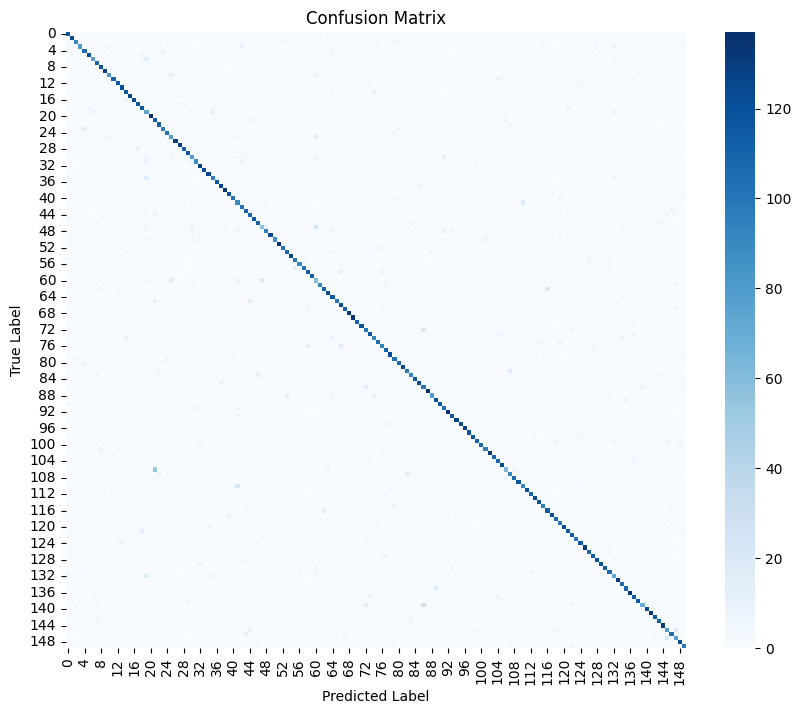

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 예측값 가져오기
y_pred = model.predict(test_generator2)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = test_generator2.classes 

# Confusion Matrix 생성
cm = confusion_matrix(y_true, y_pred_classes)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# 클래스 이름 가져오기
class_names = list(test_generator2.class_indices.keys())

# 정밀도, 재현율, F1-score 출력
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

        가지볶음       0.74      0.81      0.78       140
        간장게장       0.88      0.88      0.88       140
        갈비구이       0.72      0.65      0.68       140
         갈비찜       0.76      0.57      0.65       140
         갈비탕       0.69      0.76      0.72       140
        갈치구이       0.88      0.86      0.87       140
        갈치조림       0.64      0.54      0.59       140
         감자전       0.73      0.79      0.76       140
        감자조림       0.78      0.85      0.82       140
       감자채볶음       0.88      0.91      0.90       140
         감자탕       0.72      0.58      0.64       140
         갓김치       0.86      0.78      0.82       140
       건새우볶음       0.76      0.83      0.79       140
          경단       0.88      0.86      0.87       140
         계란국       0.79      0.83      0.81       140
        계란말이       0.89      0.90      0.90       140
         계란찜       0.89      0.88      0.88       140
       계란후라이       0.83    

In [17]:
import numpy as np

incorrect_predictions = np.sum(cm, axis=1) - np.diag(cm)
most_misclassified = np.argsort(incorrect_predictions)[-5:]  # 오분류가 많은 상위 5개 클래스

print("가장 많이 오분류된 클래스:", most_misclassified)

가장 많이 오분류된 클래스: [132 139 106  60  47]


In [28]:
import pandas as pd

# classification_report를 dictionary 형태로 변환
report_dict = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# 각 클래스별 'support'(샘플 개수)와 'precision'을 이용해 오분류 개수 계산
class_report = pd.DataFrame(report_dict).T
class_report = class_report.iloc[:-3]  # 마지막 3개(row)는 'accuracy', 'macro avg', 'weighted avg'이므로 제거

# 오분류 개수 계산: 총 샘플 수 - 정확하게 예측한 샘플 수
class_report["misclassified"] = class_report["support"] - (class_report["precision"] * class_report["support"])

# 오분류가 많은 상위 10개 클래스 선택
top_misclassified = class_report.sort_values("misclassified", ascending=False).head(10)



In [29]:
top_misclassified

,precision,recall,f1-score,support,misclassified
매운탕,0.432624,0.435714,0.434164,140.0,79.432624
고등어조림,0.457317,0.535714,0.493421,140.0,75.975610
닭계장,0.517045,0.650000,0.575949,140.0,67.613636
김치찌개,0.536913,0.571429,0.553633,140.0,64.832215
고추장진미채볶음,0.540670,0.807143,0.647564,140.0,64.306220
코다리조림,0.565891,0.521429,0.542751,140.0,60.775194
곱창전골,0.569343,0.557143,0.563177,140.0,60.291971
회무침,0.582090,0.557143,0.569343,140.0,58.507463
수육,0.586826,0.700000,0.638436,140.0,57.844311
홍어무침,0.606061,0.571429,0.588235,140.0,55.151515


In [30]:
from collections import Counter

# 오분류된 샘플만 선택 (y_true ≠ y_pred_classes)
misclassified_indices = np.where(y_true != y_pred_classes)[0]

# 오분류된 (실제 클래스, 예측 클래스) 쌍 저장
misclassified_pairs = [(class_names[y_true[i]], class_names[y_pred_classes[i]]) for i in misclassified_indices]

# 가장 자주 혼동된 음식 쌍 상위 10개 선택
most_common_misclassified = Counter(misclassified_pairs).most_common(10)

# 데이터프레임으로 변환
misclassified_df = pd.DataFrame(most_common_misclassified, columns=["(True Label, Predicted Label)", "Count"])


In [31]:
misclassified_df

,"(True Label, Predicted Label)",Count
0,"(오징어채볶음, 고추장진미채볶음)",55
1,"(편육, 수육)",29
2,"(동태찌개, 매운탕)",25
3,"(육개장, 닭계장)",22
4,"(회무침, 홍어무침)",21
5,"(메추리알장조림, 장조림)",20
6,"(보쌈, 수육)",19
7,"(닭계장, 육개장)",18
8,"(새우튀김, 오징어튀김)",17
9,"(곱창전골, 매운탕)",16


In [42]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models

# 1️⃣ ResNet101을 Feature Extractor로 사용
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # 초기에는 CNN 계층 고정

# 2️⃣ 새로운 Fully Connected Layer 추가
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(150, activation='softmax')
])


In [43]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 8, 8, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 150)            │        38,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,221,270 (164.88 MB)

 Trainable params: 563,094 (2.15 MB)

 Non-trainable params: 42,658,176 (162.73 MB)